## Fine-tune an ada classifier to distinguish between the two types of tweets: Disaster-related and the others

### Setup

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("/Users/shu/project/disaster-tweet/train.csv")
test_df = pd.read_csv("/Users/shu/project/disaster-tweet/train.csv")

### Data exploration

In [3]:
from ydata_profiling import ProfileReport

In [4]:
profile_train = ProfileReport(train_df, title="Profiling Report for train data")
profile_test= ProfileReport(test_df, title="Profiling Report for test data")

In [5]:
profile_train.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/shu/opt/anaconda3/envs/test/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/shu/opt/anaconda3/envs/test/lib/python3.11/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Data preparation

In [8]:
# Save the dataset as a jsonl file
df = pd.DataFrame(zip(train_df.text, train_df.target), columns = ['prompt','completion']).drop_duplicates(subset=['prompt'])
df.to_json("disaster2.jsonl", orient='records', lines=True)

### Fine-tuning

In [9]:
!openai tools fine_tunes.prepare_data -f disaster2.jsonl -q

Analyzing...

- Your file contains 7503 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for

In [51]:
!openai api fine_tunes.create -t '/kaggle/working/disaster2_prepared_train (1).jsonl' -v '/kaggle/working/disaster2_prepared_valid (1).jsonl' --compute_classification_metrics --classification_positive_class " 0" -m ada

[2023-06-05 16:48:57,643] error_code=None error_message='Invalid URL (GET /v1/files//kaggle/working/disaster2_prepared_train+(1).jsonl)' error_param=None error_type=invalid_request_error message='OpenAI API error received' stream_error=False
Upload progress: 100%|███████████████████████| 950k/950k [00:00<00:00, 761Mit/s]
Uploaded file from /kaggle/working/disaster2_prepared_train (1).jsonl: file-fM4Oy8Y01u3WTixwoBGU0IxL
[2023-06-05 16:49:00,409] error_code=None error_message='Invalid URL (GET /v1/files//kaggle/working/disaster2_prepared_valid+(1).jsonl)' error_param=None error_type=invalid_request_error message='OpenAI API error received' stream_error=False
Upload progress: 100%|███████████████████████| 147k/147k [00:00<00:00, 224Mit/s]
Uploaded file from /kaggle/working/disaster2_prepared_valid (1).jsonl: file-eihfmy3BeSSskNa5KbYYNhEH
Created fine-tune: ft-Z7BxOBWstH4JE2aPfojYZW1m
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the 

### Results and expected model performance

In [15]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3252,3253,1479144,26024,0.023161,1.0,1.0,NaN,NaN,NaN,0.832,0.831597,0.870909,0.894358,0.879204,0.850799


<Axes: >

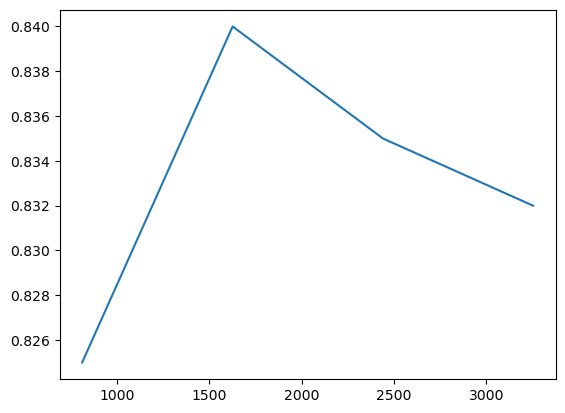

In [17]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()